 ---- TODO ---- DELETE BEFORE SUBMITING
  Formatting Instructions for Notebook
1. Structure your notebook following the same style used in previous assignments.
2. Use Markdown headings to clearly separate each major section (e.g., Load Data,
Train Classifier etc.).
3. Provide brief explanations in text cells to describe what each section does.
4. Add comments in your code to explain important implementation details.
5. Use separate code cells for different datasets and different parts of the process, such
as pre-processing, training, and evaluation.
6. Do not write all your code or all tests for different datasets in a single code cell.

IMPORTS

In [221]:
# imports
import pandas as pd
import numpy as np
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from matplotlib import pyplot as plt

TREE NODE
    This class models an individual node in the decision tree that tracks
        - If the node is a leaf
            - If it is a leaf it stores the class label
        - Else it stores refrences to the left and right children

In [222]:
class Node:
    def __init__ (self, is_leaf, class_label, left, right, SVM):
        self.is_leaf     = is_leaf
        self.class_label = class_label
        self.left        = left
        self.right       = right
        self.SVM         = SVM

GINI IMPURITY

In [223]:
def gini_impurity(series):
    size = len(series)
    series_counts = series.value_counts()

    impurity = 1
    for count in series_counts: 
        proportion = count/size
        impurity -= proportion**2

    return impurity
        

CREATE ALL BOUNDARIES - create all possible partitions of the the classes

In [224]:
# this function creates all possible boundary sets by outputting a 2d list. each inside list contains a unique boundary
def all_boundaries(classes):
    # this is assuming the the classes input will be a series
    classes = set(classes)
    boundaries     = []

    # Single classes
    # item in this for loop referes to class within set classes but python does like me calling a variable class
    for single in classes:
        other  = classes - {single}
        boundaries.append([{single}, other])
            
    class_list = sorted(classes)
        
    # Paired classes
    for r in range (len(class_list)):
        for c in range (r + 1, len(class_list)):
            pair  = {class_list[r],  class_list[c]}
            other = classes - pair
            boundaries.append([pair, other])
    return boundaries

SCORE BOUNDARY - scores a given boundary using gini impurity. lower scores indicate a better boundary

In [225]:
# this function will take in the class and data and score the boundary
def boundary_score(X, y, boundary, function):

    # boundary is a list containing 2 sets - the left set (positive) and right set (negative)
    positive_set = boundary[0]
    y_binary = []

    # turn the boundary from multiple classes to two classes
    for item in y:
        if item in positive_set:
            y_binary.append(1)
        else:
            y_binary.append(-1)

    if (len(set(y_binary)) < 2):
        return 1, None
    
    SVM = SVC(kernel = function)
    SVM.fit(X, y_binary)

    predictions = SVM.predict(X)

    # positive labelings, only count when the prediction is 1
    pos = y[predictions == 1]
    # negative, only when prediction is -1
    neg = y[predictions == -1]

    # computes the impurity of positive and negative
    gini_pos = gini_impurity(pos)
    gini_neg = gini_impurity(neg)
    
    n = len(y)
    weight_pos = len(pos) / n
    weight_neg = len(neg) / n
    # weights the impurity so uneven splits don't mess up the impurity rating
    weighted_gini = weight_pos * gini_pos + weight_neg * gini_neg
    
    # this will return gini score AND SVM
    return weighted_gini, SVM

BUILD TREE

In [226]:
def build_tree(X, y, depth, function):
    majority_class = y.mode()[0]
    # check for pure node (all points belong to one class) 
    if (len(set(y)) == 1):
        return Node(True, majority_class, None, None, None)

    # check if the support of the branch is low < 10
    if (len(y) < 10):
        return Node(True, majority_class, None, None, None)

    # check if max depth has been reached
    if (depth == MAX_TREE_HEIGHT):
        return Node(True, majority_class, None, None, None)

    # lowest score is the best score
    # best score can be 1 because gini only goes up to 0.5
    best_score = 1
    best_boundary = None
    best_SVM = None
    
    # create all possible boundaries
    boundaries = all_boundaries(y)
    
    # find the best boundary by searching for the lowest possible gini impurity
    for b in boundaries:
        b_score, SVM = boundary_score(X,y,b,function)
        if (b_score < best_score):
            best_score = b_score
            best_boundary = b
            best_SVM = SVM

    # protects from no valid boundary causing issues
    if best_boundary is None or best_SVM is None:
        return Node(True, majority_class, None, None, None)
    
    left_classes, right_classes = best_boundary

    # split the data by the boundary
    left_y = y[y.isin(left_classes)]
    right_y = y[y.isin(right_classes)]

    # if either y is 0 return a leaf
    if (len(left_y) == 0 or len(right_y) == 0):
        return Node(True, majority_class, None, None, None)
    
    left_x = X[y.isin(left_classes)]
    right_x = X[y.isin(right_classes)]

    # create left child with y only including left classes
    left_child = build_tree(left_x, left_y, depth + 1, function)
    # create right child with y only including right classes
    right_child = build_tree(right_x, right_y, depth + 1, function)

    # create the node - class label should be something
    return Node(False, None, left_child, right_child, best_SVM)

TREE TRAVERSAL - recursively traverse tree to predict class for point

In [227]:
def traverse_tree(node, point):
    if node.is_leaf:
        return node.class_label
    pred = node.SVM.predict(pd.DataFrame([point], columns=X.columns))[0]
    if pred == 1:
        return traverse_tree(node.left, point)
    else:
        return traverse_tree(node.right, point)

PLOT BOUNDARIES - draws the decision boundaries recursively

In [228]:
# AUSTIN LOOK AT PLS
def plot_boundaries(ax, node, xlim, ylim):
    if node.is_leaf:
        return
    coef = node.SVM.coef_[0]
    intercept = node.SVM.intercept_[0]
    x_vals = np.linspace(xlim[0], xlim[1], 200)
    y_vals = (-intercept - coef[0] * x_vals) / coef[1]
    ax.plot(x_vals, y_vals, 'b--', linewidth=1)
    plot_boundaries(ax, node.left, xlim, ylim)
    plot_boundaries(ax, node.right, xlim, ylim)

REDRAW after selecting a point

In [229]:
def redraw(fig, ax, tree, X, y, xlim, ylim, selected_point = None, label_text = None):
        ax.clear()
        ax.scatter(X[:, 0], X[:, 1], c=y)
        plot_boundaries(ax, tree, xlim, ylim)
        if selected_point is not None:
            ax.scatter([selected_point[0]], [selected_point[1]], c='r', s=80)
            ax.set_title(label_text)
        ax.set_xlim(xlim)
        ax.set_ylim(ylim)
        fig.canvas.draw()

INTERACTIVE PLOT - given a tree, X, and y, creates interactive graph

In [230]:
def plot(tree, X,y):
    
    %matplotlib widget

    minX0D = np.min(X[:, 0])
    maxX0D = np.max(X[:, 0])
    minX1D = np.min(X[:, 1])
    maxX1D = np.max(X[:, 1])
    xlim = (minX0D, maxX0D)
    ylim = (minX1D, maxX1D)
    
    fig, ax = plt.subplots()
    
    plt.scatter(X[:, 0], X[:, 1], marker='o', c=y)
    ax.set_xlim([minX0D, maxX0D])
    ax.set_ylim([minX1D, maxX1D])
    
    text=plt.xlabel("No selection yet")

    # when clicked, will predict the class of the point and draw the point
    def onclick(event):
        if event.inaxes is not None:   
            tx = 'xdata=%f, ydata=%f' % (event.xdata, event.ydata)
            pt = [event.xdata, event.ydata]
            predicted_class = traverse_tree(tree, pt)
            label_text = f"{tx}, Predicted Class: {predicted_class}"
            redraw(fig, ax, tree, X, y, xlim, ylim, selected_point=pt, label_text=label_text)
        else:
            print('Clicked outside of an axis.')
        
    fig.canvas.mpl_connect('button_press_event', onclick)
    redraw(fig, ax, tree, X, y, xlim, ylim)
    return fig, ax

LOAD DATA

In [231]:
data1_train = pd.read_csv("data/Data1Train.csv")
data2_train = pd.read_csv("data/Data2Train.csv")
data3_train = pd.read_csv("data/Data3Train.csv")
data4_train = pd.read_csv("data/Data4Train.csv")
data1_test = pd.read_csv("data/Data1Test.csv")
data2_test = pd.read_csv("data/Data2Test.csv")
data3_test = pd.read_csv("data/Data3Test.csv")
data4_test = pd.read_csv("data/Data4Test.csv")

# display data set 1
data1_train.head()

,Class,x,y
0,4,0.803929,0.230782
1,1,0.242077,0.840158
2,4,0.687047,0.280138
3,1,0.086210,0.765054
4,2,0.589790,0.809382


Analyzing data1

Dataset 1 Test Accuracy: 1.00


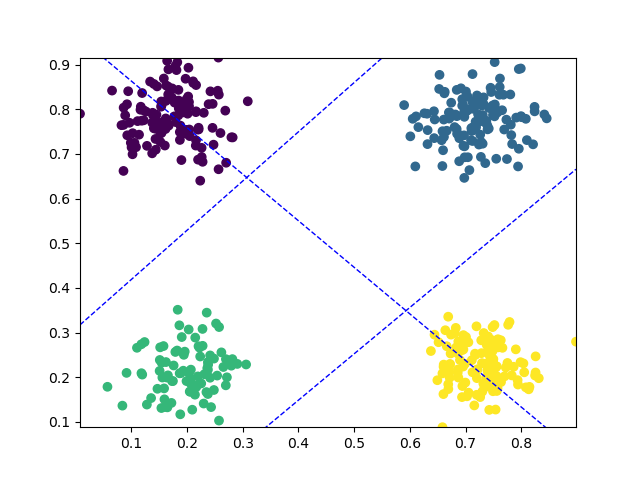

In [232]:
MAX_TREE_HEIGHT = math.ceil(math.log2(4)) + 1
X_train = data1_train[['x', 'y']]
y_train = data1_train['Class']
X_test = data1_test[['x','y']]
y_test = data1_test['Class']

# builds tree
tree = build_tree(X_train, y_train, 0, "linear")
# plots points from training data
plot(tree, X_train.to_numpy(), y_train.to_numpy())

# predicts the class of each test data point and measures accuracy
predicted_classes = []
for _, point in X_test.iterrows():
    predicted_classes.append(traverse_tree(tree, point))
acc = accuracy_score(y_test.to_numpy(), predicted_classes)
print(f"Dataset 1 Test Accuracy: {acc:.2f}")

Analyzing data2

Dataset 2 Test Accuracy: 1.00


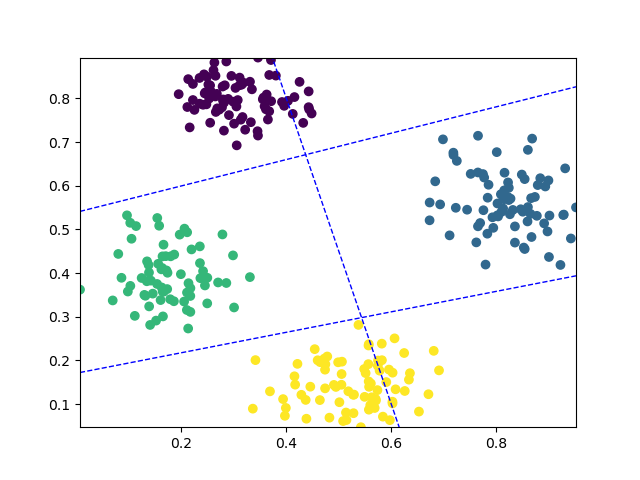

In [233]:
MAX_TREE_HEIGHT = math.ceil(math.log2(4)) + 1
X_train = data2_train[['x', 'y']]
y_train = data2_train['Class']
X_test = data2_test[['x','y']]
y_test = data2_test['Class']

# builds tree
tree2 = build_tree(X_train, y_train, 0, "linear")
# plots points from training data
plot(tree2, X_train.to_numpy(), y_train.to_numpy())

# predicts the class of each test data point and measures accuracy
predicted_classes = []
for _, point in X_test.iterrows():
    predicted_classes.append(traverse_tree(tree2, point))
acc = accuracy_score(y_test.to_numpy(), predicted_classes)
print(f"Dataset 2 Test Accuracy: {acc:.2f}")

Analyzing data3

Dataset 3 Test Accuracy: 0.85


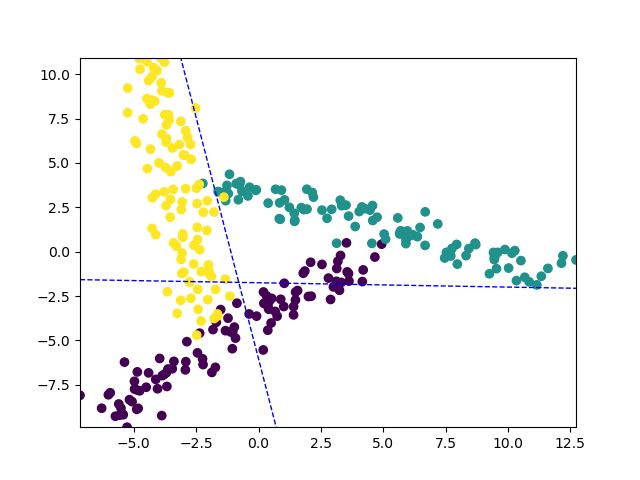

In [234]:
MAX_TREE_HEIGHT = math.ceil(math.log2(3)) + 1
random_state = 1234
X_train = data3_train[['x', 'y']]
y_train = data3_train['Class']
X_test = data3_test[['x','y']]
y_test = data3_test['Class']

# builds tree
tree3 = build_tree(X_train, y_train, 0, "linear")
# plots points from training data
plot(tree3, X_train.to_numpy(), y_train.to_numpy())

# predicts the class of each test data point and measures accuracy
predicted_classes = []
for _, point in X_test.iterrows():
    predicted_classes.append(traverse_tree(tree3, point))
acc = accuracy_score(y_test.to_numpy(), predicted_classes)
print(f"Dataset 3 Test Accuracy: {acc:.2f}")

Analyzing data4

In [235]:
MAX_TREE_HEIGHT = math.ceil(math.log2(4)) + 1
random_state = 1234
X_train = data4_train[['x', 'y']]
y_train = data4_train['Class']
X_test = data4_test[['x','y']]
y_test = data4_test['Class']

# Data set 4 is nonlinear so scale x
scaler = StandardScaler()
X_train_scale = scaler.fit_transform(X_train)
X_test_scale = scaler.fit_transform(X_test)

tree4 = build_tree(X_scale, y, 0, "rbf")
plot(tree4, X_train.to_numpy(), y_train.to_numpy())
predicted_classes = []
for _, point in X_test.iterrows():
    predicted_classes.append(traverse_tree(tree4, point))
acc = accuracy_score(y_test.to_numpy(), predicted_classes)
print(f"Dataset 4 Test Accuracy: {acc:.2f}")

ValueError: Found input variables with inconsistent numbers of samples: [432, 304]